# 로이터 뉴스 기사 분류

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import reuters

In [29]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

print("훈련용 뉴스 기사 : {}".format(len(X_train)))
print("테스트용 뉴스 기사 : {}".format(len(X_test)))

num_classes = len(set(y_train))
print("카테고리 : {}".format(num_classes))

훈련용 뉴스 기사 : 8982
테스트용 뉴스 기사 : 2246
카테고리 : 46


In [30]:
print("첫 번쨰 훈련용 뉴스 기사 레이블 : ",y_train[0])
print("첫 번째 훈련용 뉴스 기사 : ", X_train[0])

첫 번쨰 훈련용 뉴스 기사 레이블 :  3
첫 번째 훈련용 뉴스 기사 :  [1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


각 숫자는 각 단어의 등장 빈도 등수를 나타낸다.

뉴스 기사의 최대 길이 : 2376
뉴스 기사의 평균 길이 : 145.5398574927633


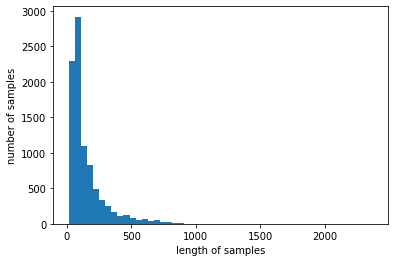

In [31]:
print("뉴스 기사의 최대 길이 : {}".format(max(len(sample) for sample in X_train)))
print("뉴스 기사의 평균 길이 : {}".format(sum(map(len, X_train))/len(X_train)))

plt.hist([len(sample) for sample in X_train], bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

- 관측 결과
    - 대부분의 뉴스 길이가 100~200 사이의 길이를 가진다

/Users/sunny/miniforge3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


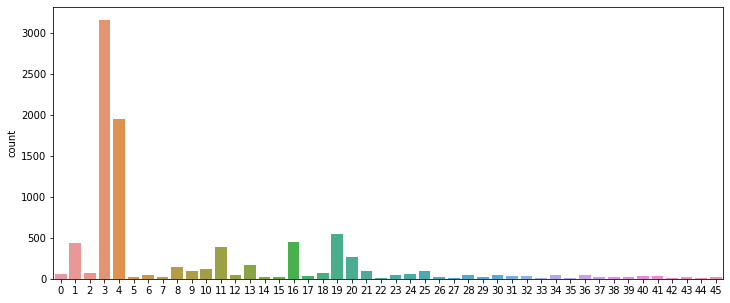

In [32]:
plt.figure(figsize=(12,5))
sns.countplot(y_train)
plt.show()

- 관측결과
    - label 이 3,4 가 가장 많다.
    - 정확한 개수 파악해보기

In [33]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수 ")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수 
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [34]:
word_to_index = reuters.get_word_index()

In [35]:
index_to_word = {}
for key,value in word_to_index.items():
    index_to_word[value+3] = key

In [36]:
print("빈도수 상위 1번 단어 : {}".format(index_to_word[4]))

빈도수 상위 1번 단어 : the


In [37]:
print("빈도수 상위 1번 단어 : {}".format(index_to_word[210]))


빈도수 상위 1번 단어 : only


- 로이터 뉴스 데이터셋에서는 index_to_word 을 아래와 같이 패딩해야한다.
    - 숫자 0 : 패딩을 의미하는 토큰 = pad
    - 숫자 1 : 문장의 시작을 의미 = sos
    - 숫자 2 : OOV를 위한 토큰 = unk

In [38]:
# index_to_word를 이용해서 첫번쨰 훈련용 뉴스 기사 확인하기
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### LSTM 으로 로이터 뉴스 분류하기

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

vocab_size = 1000
max_len = 100

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=vocab_size, test_split=0.2)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [40]:
embedding_dim = 128
hidden_units = 128
num_classes = 46

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30


2022-02-26 19:27:06.458297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-26 19:27:06.588205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-26 19:27:06.766799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - ETA: 0s - loss: 2.7080 - acc: 0.3457

2022-02-26 19:27:11.299831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-26 19:27:11.348650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_acc improved from -inf to 0.36198, saving model to best_model.h5
71/71 [==============================] - 6s 70ms/step - loss: 2.7080 - acc: 0.3457 - val_loss: 2.4188 - val_acc: 0.3620
Epoch 2/30
70/71 [============================>.] - ETA: 0s - loss: 2.4082 - acc: 0.3517
Epoch 00002: val_acc did not improve from 0.36198
71/71 [==============================] - 4s 58ms/step - loss: 2.4082 - acc: 0.3517 - val_loss: 2.4119 - val_acc: 0.3620
Epoch 3/30
70/71 [============================>.] - ETA: 0s - loss: 2.3996 - acc: 0.3542
Epoch 00003: val_acc did not improve from 0.36198
71/71 [==============================] - 4s 60ms/step - loss: 2.4007 - acc: 0.3538 - val_loss: 2.4387 - val_acc: 0.2449
Epoch 4/30
70/71 [============================>.] - ETA: 0s - loss: 2.2557 - acc: 0.4244
Epoch 00004: val_acc did not improve from 0.36198
71/71 [==============================] - 5s 64ms/step - loss: 2.2566 - acc: 0.4237 - val_loss: 2.5223 - val_acc: 0.2124
Epoch 5/30
70/71 [==

In [41]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

2022-02-26 19:28:27.839081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-26 19:28:27.888506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


71/71 [==============================] - 2s 19ms/step - loss: 1.8831 - acc: 0.5272

 테스트 정확도: 0.5272


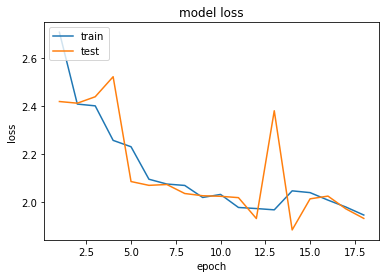

In [42]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()